# IF867 - Introdução à Aprendizagem Profunda
# 1ª atividade prática

Discente(s): Nathalia Fernanda de Araújo Barbosa (nfab)

Período: 9º período

## Instruções e Requisitos
- Objetivo: Implementar e treinar um Multilayer Perceptron (MLP), inteiramente em [NumPy](https://numpy.org/doc/stable/) ou [Numba](https://numba.readthedocs.io/en/stable/index.html), sem o uso de bibliotecas de aprendizado profundo.
- A atividade pode ser feita em dupla.

### Tarefas

__Implementação (50%):__

- Construa um MLP com uma camada de entrada, pelo menos duas camadas ocultas e uma camada de saída.
- Implemente pelo menos duas funções de ativação diferentes para as camadas ocultas; use Sigmoid e Linear para a camada de saída.
- Implemente forward e backpropagation.
- Implemente um otimizador de sua escolha, adequado ao problema abordado.
- Implemente as funções de treinamento e avaliação.

__Aplicação (30%):__

  Teste se os seus modelos estão funcionando bem com as seguintes tarefas:
  - Regressão
  - Classificação binária

__Experimentação (20%):__

  Teste os seus modelos com variações na arquitetura, no pré-processamento, etc. Escolha pelo menos uma das seguintes opções:
  - Variações na inicialização de pesos
  - Variações na arquitetura
  - Implementação de técnicas de regularização
  - Visualização das ativações e gradientes

***Bônus:*** Implemente o MLP utilizando uma biblioteca de machine learning (ex.: [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/?hl=pt-br), [tinygrad](https://docs.tinygrad.org/), [Jax](https://jax.readthedocs.io/en/latest/quickstart.html)) e teste-o em uma das aplicações e em um dos experimentos propostos. O bônus pode substituir um dos desafios de aplicação ou experimentos feitos em NumPy, ou simplesmente somar pontos para a pontuação geral.

### Datasets recomendados:
Aqui estão alguns datasets recomendados, mas fica a cargo do aluno escolher os datasets que utilizará na atividade, podendo escolher um dataset não listado abaixo.
- Classificação

  - [Iris](https://archive.ics.uci.edu/dataset/53/iris)
  - [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
  - [CDC Diabetes Health Indicators](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators)

- Regressão

  - [Air Quality](https://archive.ics.uci.edu/dataset/360/air+quality)
  - [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance)
  - [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality)

### Requisitos para Entrega

Um notebook Jupyter (de preferência, o link do colab) ou script Python contendo:

- Código: Implementação completa da MLP.
- Gráficos e Análises: Gráficos da curva de perda, ativações, gradientes e insights do treinamento, resultantes dos experimentos com parada antecipada e diferentes técnicas de regularização.
- Relatório: Um breve relatório detalhando o impacto de várias configurações de hiperparâmetros(ex.: inicialização de pesos, número de camadas ocultas e neurônios) e métodos de regularização no desempenho do modelo.


# Importando bibliotecas

In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 💐 Primeiro dataset - Iris

## Mexendo no Dataset

Primeiro, começamos importando o dataset para classificação, Iris, da UCI. É um dos primeiros conjuntos de dados utilizados na literatura sobre métodos de classificação e amplamente utilizado em estatística e aprendizado de máquina. O conjunto de dados contém 3 classes com 50 instâncias cada, onde cada classe se refere a um tipo de planta do gênero Iris. Uma das classes é linearmente separável das outras duas; as últimas não são linearmente separáveis entre si.

In [3]:
# Fetch dataset
iris = fetch_ucirepo(id=53)

# Features (X) and targets (y) as pandas DataFrames
X = iris.data.features
y = iris.data.targets

# Combine features and targets into a single DataFrame
iris_df = pd.concat([X, y], axis=1)

# Save to CSV
iris_df.to_csv("iris_dataset.csv", index=False)

In [4]:
iris_df.shape

(150, 5)

In [5]:
iris_df.dtypes

,0
sepal length,float64
sepal width,float64
petal length,float64
petal width,float64
class,object


In [6]:
print(iris_df.head())
print(iris_df.tail())

   sepal length  sepal width  petal length  petal width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
     sepal length  sepal width  petal length  petal width           class
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica


Antes de iniciarmos o treinamento das MLPs, precisamos converter a coluna "class" para valores binários.

In [7]:
unique_classes = iris_df["class"].unique()
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}

iris_df["class"] = iris_df["class"].map(class_mapping)

print("Mapping aplicado:", class_mapping)
print("\nFormato (Shape):", iris_df.shape)
print("\nTipos de dados:\n", iris_df.dtypes)

Mapping aplicado: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

Formato (Shape): (150, 5)

Tipos de dados:
 sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
class             int64
dtype: object


### Identificando outliers

Abaixo estão os valores numéricos da base de dados. É possível examinar várias informações importantes, como a quantidade de dados presentes em cada campo, a média, o desvio padrão, os valores mínimo e máximo e os quartis. Essas informações permitem compreender a distribuição dos dados em cada campo e auxiliam na identificação de possíveis outliers ou padrões interessantes na base de dados.

In [8]:
iris_df.describe()

,sepal length,sepal width,petal length,petal width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


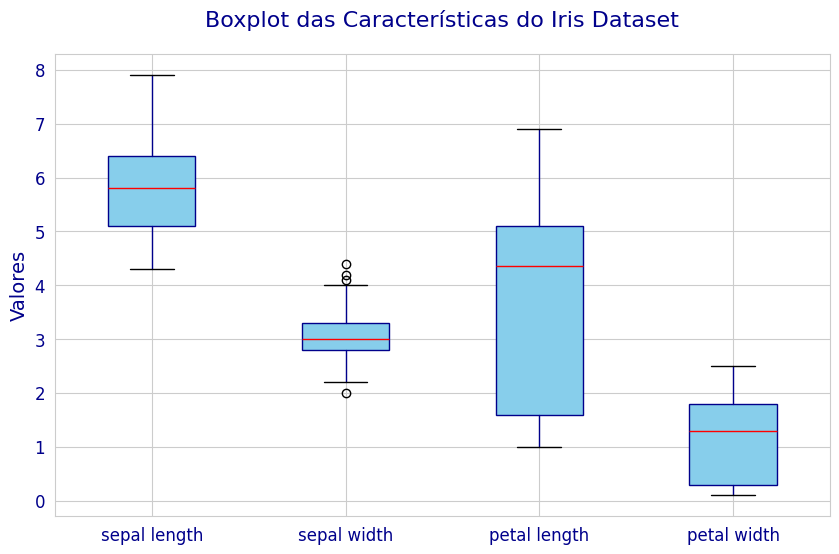

In [9]:
sns.set_palette("pastel")
sns.set_style("whitegrid")

features = ["sepal length", "sepal width", "petal length", "petal width"]
plt.figure(figsize=(10, 6))
box = iris_df[features].boxplot(patch_artist=True, boxprops=dict(facecolor='skyblue', color='darkblue'), medianprops=dict(color='red'), whiskerprops=dict(color='darkblue'))

plt.title("Boxplot das Características do Iris Dataset", fontsize=16, color="darkblue", pad=20)
plt.ylabel("Valores", fontsize=14, color="darkblue")
plt.xticks(fontsize=12, color="darkblue")
plt.yticks(fontsize=12, color="darkblue")

plt.show()

Como existem poucos valores outlier, e apenas na coluna "sepal width", optamos por não removê-los.

# 🍷 Segundo dataset - Wine Quality

## Mexendo no Dataset

Primeiro, começamos importando o dataset para regressão, Wine Quality, da UCI.

Os dois conjuntos de dados estão relacionados às variantes tinta e branca do vinho português "Vinho Verde". Devido a questões de privacidade e logística, apenas variáveis físico-químicas (entradas) e sensoriais (saída) estão disponíveis (por exemplo, não há dados sobre os tipos de uva, marca do vinho, preço de venda do vinho, etc.).

Esses conjuntos de dados podem ser vistos como tarefas de classificação ou regressão. As classes são ordenadas e desbalanceadas (por exemplo, há muitos mais vinhos normais do que excelentes ou ruins). Algoritmos de detecção de outliers poderiam ser usados para detectar os poucos vinhos excelentes ou ruins. Além disso, não temos certeza se todas as variáveis de entrada são relevantes. Portanto, pode ser interessante testar métodos de seleção de características.

In [10]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# Combine features and targets into a single DataFrame
wine_df = pd.concat([X, y], axis=1)

# Save to CSV
wine_df.to_csv("wine_df.csv", index=False)

In [11]:
wine_df.shape

(6497, 12)

In [12]:
wine_df.dtypes

,0
fixed_acidity,float64
volatile_acidity,float64
citric_acid,float64
residual_sugar,float64
chlorides,float64
free_sulfur_dioxide,float64
total_sulfur_dioxide,float64
density,float64
pH,float64
sulphates,float64


In [13]:
print(wine_df.head())
print(wine_df.tail())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

### Identificando outliers

Abaixo estão os valores numéricos da base de dados. É possível examinar várias informações importantes, como a quantidade de dados presentes em cada campo, a média, o desvio padrão, os valores mínimo e máximo e os quartis. Essas informações permitem compreender a distribuição dos dados em cada campo e auxiliam na identificação de possíveis outliers ou padrões interessantes na base de dados.

In [14]:
wine_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


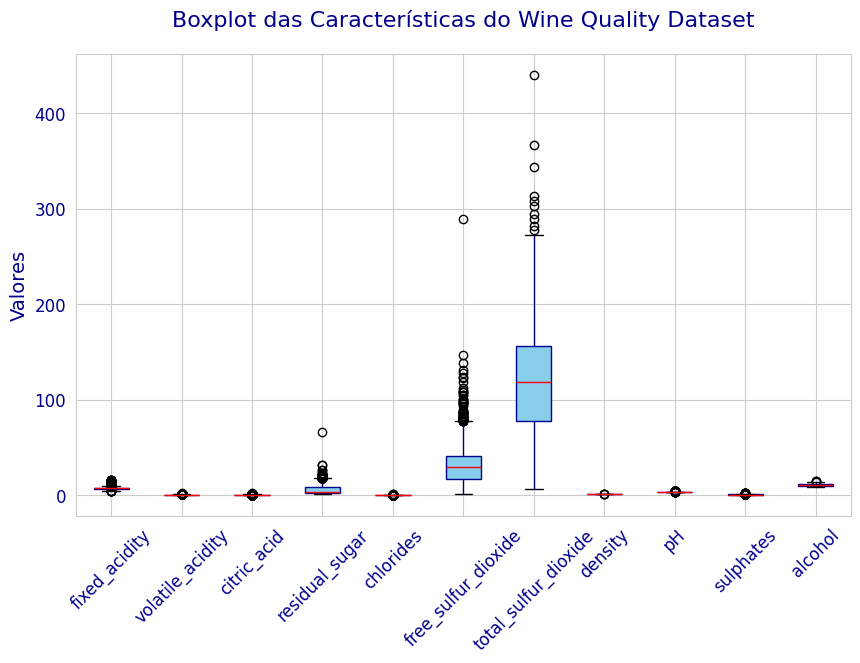

In [15]:
sns.set_palette("pastel")
sns.set_style("whitegrid")

features = [
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density",
    "pH", "sulphates", "alcohol"
]

plt.figure(figsize=(10, 6))
box = wine_df[features].boxplot(
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='darkblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='darkblue')
)

plt.title("Boxplot das Características do Wine Quality Dataset", fontsize=16, color="darkblue", pad=20)
plt.ylabel("Valores", fontsize=14, color="darkblue")
plt.xticks(fontsize=12, color="darkblue", rotation=45)
plt.yticks(fontsize=12, color="darkblue")

plt.show()

Como existem vários valores outlier nas features, optamos por removê-los. Para tal, utilizamos a regra do 1,5 IQR. Essa regra define limites superior e inferior baseados no intervalo interquartil (IQR) dos dados. Valores que estiverem acima ou abaixo desses limites são considerados outliers e removidos do conjunto de dados.

In [16]:
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

features = [
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density",
    "pH", "sulphates", "alcohol"
]

wine_df_cleaned = remove_outliers(wine_df, features)

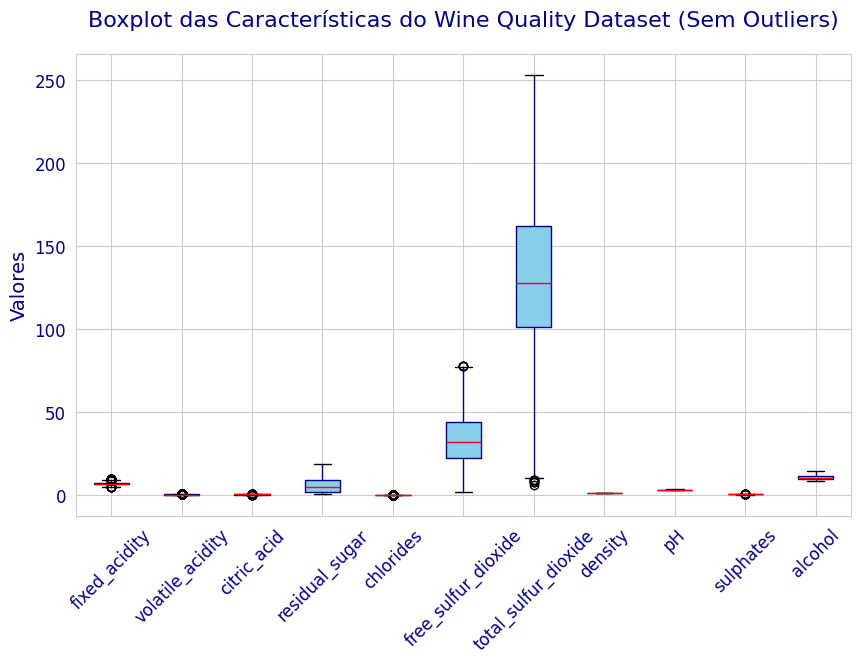

In [17]:
plt.figure(figsize=(10, 6))
box = wine_df_cleaned[features].boxplot(
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='darkblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='darkblue')
)

plt.title("Boxplot das Características do Wine Quality Dataset (Sem Outliers)", fontsize=16, color="darkblue", pad=20)
plt.ylabel("Valores", fontsize=14, color="darkblue")
plt.xticks(fontsize=12, color="darkblue", rotation=45)
plt.yticks(fontsize=12, color="darkblue")

plt.show()

# Implementação - Construção das MLPs

O objetivo é construir uma MLP com uma camada de entrada, pelo menos duas camadas ocultas e uma camada de saída.

Lembrando que os nossos df utilizados são `iris_df` e `wine_df_cleaned`, que serão postos à prova no próximo tópico.

### Funções de ativação

- Implemente pelo menos duas funções de ativação diferentes para as camadas ocultas; use Sigmoid e Linear para a camada de saída.

In [18]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  sig = sigmoid(x)
  return sig * (1 - sig)

def reLU(x):
  return np.maximum(0,x)

def reLU_derivative(x):
  return np.where(x>0,1,0)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def test_act_value(x_value):
  print(f"Testando as funções de ativação com o valor {x_value}:")

  sigmoid_result = sigmoid(x_value)
  print(f"Sigmoid({x_value}) = {sigmoid_result:.4f}")

  reLU_result = reLU(x_value)
  print(f"ReLU({x_value}) = {reLU_result:.4f}")

  tanh_result = tanh(x_value)
  print(f"Tanh({x_value}) = {tanh_result:.4f}")
  print("\n")

test_act_value(2)
test_act_value(15)
test_act_value(-2)
test_act_value(-15)

Testando as funções de ativação com o valor 2:
Sigmoid(2) = 0.8808
ReLU(2) = 2.0000
Tanh(2) = 0.9640


Testando as funções de ativação com o valor 15:
Sigmoid(15) = 1.0000
ReLU(15) = 15.0000
Tanh(15) = 1.0000


Testando as funções de ativação com o valor -2:
Sigmoid(-2) = 0.1192
ReLU(-2) = 0.0000
Tanh(-2) = -0.9640


Testando as funções de ativação com o valor -15:
Sigmoid(-15) = 0.0000
ReLU(-15) = 0.0000
Tanh(-15) = -1.0000




### Forward e Backpropagation

A função `init_weights` abaixo tem como objetivo inicializar os pesos e vieses de uma rede neural com três camadas (duas ocultas e uma de saída). A inicialização correta dos parâmetros ajuda a evitar problemas como a saturação das funções de ativação, que podem prejudicar a aprendizagem da rede.

Os pesos são inicializados com valores aleatórios retirados de uma distribuição normal. Porém, esses pesos são multiplicados por um fator de 0.01. Isso ajuda a controlar o tamanho dos valores iniciais e garante que o treinamento comece de uma maneira mais estável. Já os biases são inicializados com zeros.

In [19]:
def init_weights(X, y):
  # Inicialização dos pesos
  np.random.seed(42)
  input_size = X.shape[1]
  hidden_size_1 = 10
  hidden_size_2 = 10
  output_size = y.shape[1]

  global W1, b1, W2, b2, W3, b3

  # Inicializar pesos e bias
  W1 = np.random.randn(input_size, hidden_size_1) * 0.01
  b1 = np.zeros((1, hidden_size_1))

  W2 = np.random.randn(hidden_size_1, hidden_size_2) * 0.01
  b2 = np.zeros((1, hidden_size_2))

  W3 = np.random.randn(hidden_size_2, output_size) * 0.01
  b3 = np.zeros((1, output_size))

- Implemente forward e backpropagation.

Abaixo, as funções `forward_sigmoid` e `forward_linear` implementam o forward pass de uma rede neural com três camadas, sendo duas camadas ocultas e uma camada de saída. Ambas as funções seguem um fluxo similar, mas com diferenças na ativação da camada de saída.

Na função `forward_sigmoid`, os dados de entrada `X` passam pela primeira camada oculta, onde é calculado o valor de `z1` multiplicando a entrada `X` pelos pesos `W1` e somando o viés `b1`. Esse valor é então passado pela função de ativação ReLU, que adiciona não linearidade e ajuda a rede a aprender padrões mais complexos. O mesmo processo é repetido na segunda camada oculta: calculando `z2` e aplicando a função de ativação tanh, que retorna valores entre -1 e 1. Por fim, a camada de saída calcula `z3`, e a função sigmoide é aplicada para gerar a previsão final `y_pred`, que será uma probabilidade entre 0 e 1.

Por outro lado, na `forward_linear`, o processo é quase o mesmo, mas a ativação final é linear. Ou seja, em vez de aplicar a função sigmoide à camada de saída, a função retorna diretamente o valor de `z3`, que pode ser qualquer valor real.

A função de ativação da camada de saída é especialmente importante para determinar o tipo de problema que a rede está resolvendo: uma função sigmoide é comumente usada para problemas de classificação binária, enquanto a ativação linear na camada de saída é mais comum em problemas de regressão, onde a rede precisa gerar valores contínuos como saída.

In [20]:
def forward_sigmoid(X):
  # Primeira camada oculta
  z1 = np.dot(X, W1) + b1
  a1 = reLU(z1)

  # Segunda camada oculta
  z2 = np.dot(a1, W2) + b2
  a2 = tanh(z2)

  # Camada de saída
  z3 = np.dot(a2, W3) + b3
  y_pred = sigmoid(z3)

  return y_pred, a1, a2

def forward_linear(X):
  # Primeira camada oculta
  z1 = np.dot(X, W1) + b1
  a1 = reLU(z1)

  # Segunda camada oculta
  z2 = np.dot(a1, W2) + b2
  a2 = tanh(z2)

  # Camada de saída
  z3 = np.dot(a2, W3) + b3
  y_pred = z3

  return y_pred, a1, a2

A função `backward` realiza o backpropagation da rede neural, que é o processo de cálculo dos gradientes necessários para ajustar os pesos durante o treinamento. O objetivo da retropropagação é calcular como os pesos devem ser ajustados com base no erro da rede, para que ela melhore suas previsões ao longo do tempo.

In [21]:
def backward(X, y, y_pred, a1, a2):
  m = X.shape[0]

  # Gradiente da saída (erro na camada de saída)
  dz3 = y_pred - y
  dW3 = np.dot(a2.T, dz3) / m
  db3 = np.sum(dz3, axis=0, keepdims=True) / m

  # Gradiente da segunda camada oculta
  dz2 = np.dot(dz3, W3.T) * tanh_derivative(a2)
  dW2 = np.dot(a1.T, dz2) / m
  db2 = np.sum(dz2, axis=0, keepdims=True) / m

  # Gradiente da primeira camada oculta
  dz1 = np.dot(dz2, W2.T) * reLU_derivative(a1)
  dW1 = np.dot(X.T, dz1) / m
  db1 = np.sum(dz1, axis=0, keepdims=True) / m

  return dW1, db1, dW2, db2, dW3, db3


- Implemente um otimizador de sua escolha, adequado ao problema abordado.

O escolhido foi o Gradiente Descendente. A função `update_weights` é responsável por atualizar os pesos e vieses da rede neural após o cálculo dos gradientes no processo de backpropagation. Ela usa o gradiente calculado e a taxa de aprendizado para ajustar os parâmetros, subtraindo o produto do gradiente pelo learning rate de cada peso e viés. Os pesos (`W1`, `W2`, `W3`) e os vieses (`b1`, `b2`, `b3`) são ajustados em direção oposta ao gradiente, seguindo o princípio do gradiente descendente, com o objetivo de minimizar a função de custo e melhorar as previsões do modelo durante o treinamento.


In [22]:
def update_weights(dW1, db1, dW2, db2, dW3, db3, learning_rate):
  # Acesso às variáveis globais
  global W1, b1, W2, b2, W3, b3

  # Atualização dos pesos e vieses usando gradientes
  W1 -= learning_rate * dW1
  b1 -= learning_rate * db1
  W2 -= learning_rate * dW2
  b2 -= learning_rate * db2
  W3 -= learning_rate * dW3
  b3 -= learning_rate * db3

### Treinamento e Avaliação

- Implemente as funções de treinamento e avaliação.

As funções de perda fornecem métricas para avaliar o desempenho do modelo durante o treinamento. A `cross_entropy_loss` é usada para problemas de classificação binária e mede a discrepância entre as previsões (`y_pred`) e os valores reais (`y_true`) usando a entropia cruzada. Para evitar logaritmos indefinidos, um pequeno valor (`epsilon`) é adicionado para limitar os valores de `y_pred` entre `1e-10` e `1 - 1e-10`. Ela soma o erro entre a previsão e o valor real, penalizando mais previsões incorretas.

A `mse_loss` (erro quadrático médio) é usada em problemas de regressão e calcula a média dos quadrados das diferenças entre as previsões e os valores reais. Ela penaliza mais previsões distantes dos valores reais.

Ambos os tipos de função de perda são essenciais para ajustar os parâmetros do modelo durante o treinamento, guiando o processo de otimização.

In [23]:
# Função de perda
def cross_entropy_loss(y_pred, y_true):
  num_samples = y_true.shape[0]
  epsilon = 1e-10
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
  loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / num_samples
  return loss

def mse_loss(y_pred, y_true):
  m = y_true.shape[0]
  loss = np.sum((y_pred - y_true) ** 2) / m
  return loss

Abaixo temos duas funções principais para treinar e avaliar um modelo de rede neural com diferentes funções de ativação (sigmoid ou linear).

A função `train` realiza o treinamento do modelo, executando um número definido de épocas (epochs). Dentro de cada época, ela faz a passagem para frente (`forward`), calcula a perda (loss) com base na função de ativação escolhida, realiza o backpropagation (`backward`) para calcular os gradientes, e atualiza os pesos usando os gradientes calculados. As perdas por época são armazenadas em uma lista e podem ser visualizadas em um gráfico após o treinamento.

Já a função `evaluate` é utilizada para avaliar o desempenho do modelo após o treinamento, usando dados de teste. Dependendo da função de ativação especificada (`linear` ou `sigmoid`), ela faz a previsão com a função de ativação apropriada. A função de avaliação compara as previsões com os valores reais de classe, calcula métricas como `accuracy`, `precision`, `recall`, e `f1` (todas usando o cálculo ponderado), e exibe essas métricas. Além disso, é gerada e exibida a matriz de confusão, que ajuda a visualizar o desempenho do modelo na classificação.

In [24]:
def evaluate(X_test, y_test, func):
    if func == "linear":
        y_pred, _, _ = forward_linear(X_test)
    elif func == "sigmoid":
        y_pred, _, _ = forward_sigmoid(X_test)

    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_test, axis=1)

    # Calcular as métricas
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=1)
    recall = recall_score(y_true_class, y_pred_class, average='weighted', zero_division=1)
    f1 = f1_score(y_true_class, y_pred_class, average='weighted', zero_division=1)

    # Exibir as métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plotar a matriz de confusão
    cm = confusion_matrix(y_true_class, y_pred_class)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot(cmap=plt.cm.viridis)
    plt.title(f"Confusion Matrix ({func})")
    plt.show()

def train(X_train, y_train, func, epochs=100, learning_rate=0.01):
    losses = []
    for epoch in range(epochs):
        # Forward pass
        if func == "linear":
            y_pred, a1, a2 = forward_linear(X_train)
            loss = mse_loss(y_pred, y_train)
        elif func == "sigmoid":
            y_pred, a1, a2 = forward_sigmoid(X_train)
            loss = cross_entropy_loss(y_pred, y_train)
        dW1, db1, dW2, db2, dW3, db3 = backward(X_train, y_train, y_pred, a1, a2)

        # Atualizar pesos
        update_weights(dW1, db1, dW2, db2, dW3, db3, learning_rate)

        losses.append(loss)

        #if epoch % 10 == 0:
        #    print(f"Epoch {epoch}, Loss: {loss:.4f}")

    # Plotar perdas
    plt.plot(range(epochs), losses, label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

# Aplicação nos Datasets

 ## Iris

In [25]:
# Separar variáveis independentes (features) e dependentes (classe)
features = ["sepal length", "sepal width", "petal length", "petal width"]

X = iris_df[features].values
y = iris_df["class"].values

# Codificar a classe (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))  # Transformar y para um vetor coluna antes de aplicar o encoding

# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Iniciando o treinamento com função de ativação Sigmoid:


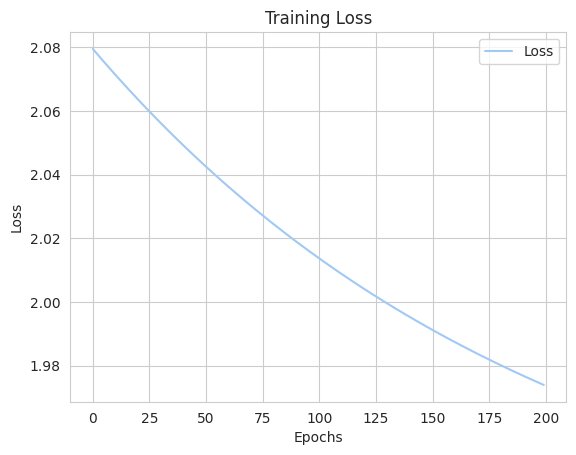

Accuracy: 0.3000
Precision: 0.7900
Recall: 0.3000
F1 Score: 0.1385


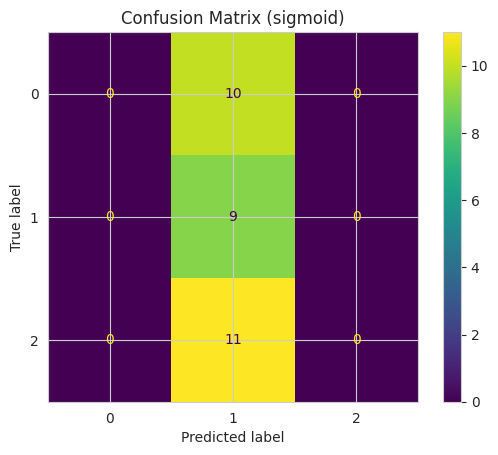

Treinamento concluído com a função de ativação Sigmoid.

Iniciando o treinamento com função de ativação Linear:


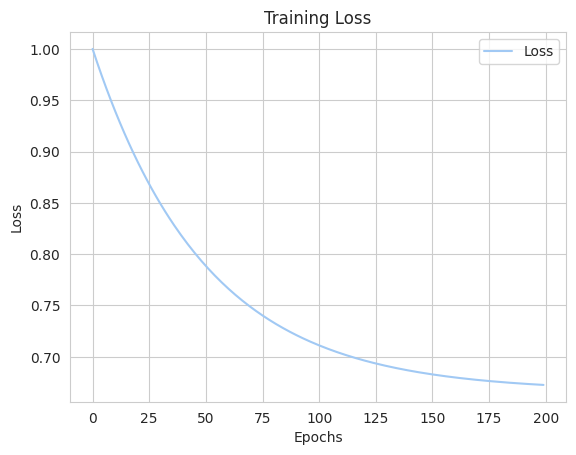

Accuracy: 0.3000
Precision: 0.7900
Recall: 0.3000
F1 Score: 0.1385


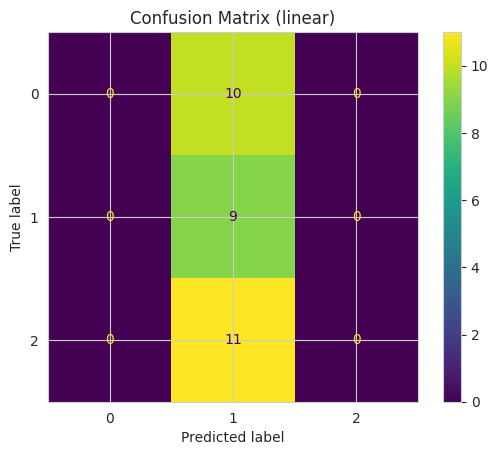

Treinamento concluído com a função de ativação Linear.


In [26]:
print("===================================")
print("Iniciando o treinamento com função de ativação Sigmoid:")
init_weights(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid.")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear:")
init_weights(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear.")
print("===================================")

 ## Wine Quality

In [27]:
# Separar variáveis independentes (features) e dependentes (classe)
features = [
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density",
    "pH", "sulphates", "alcohol"
]

X = wine_df_cleaned[features].values
y = wine_df_cleaned["quality"].values

# Codificar a classe (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))  # Transformar y para um vetor coluna antes de aplicar o encoding

# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Iniciando o treinamento com função de ativação Sigmoid:


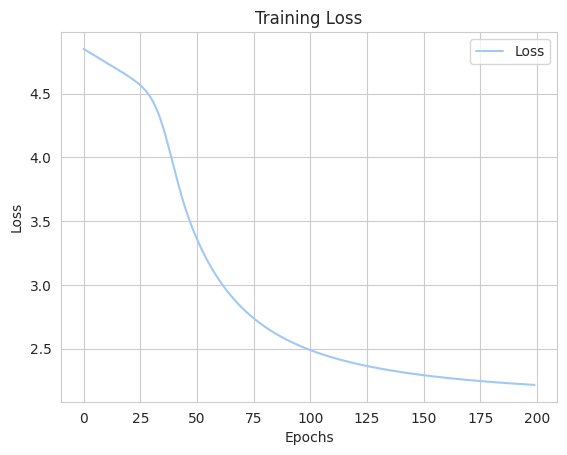

Accuracy: 0.4489
Precision: 0.7526
Recall: 0.4489
F1 Score: 0.2782


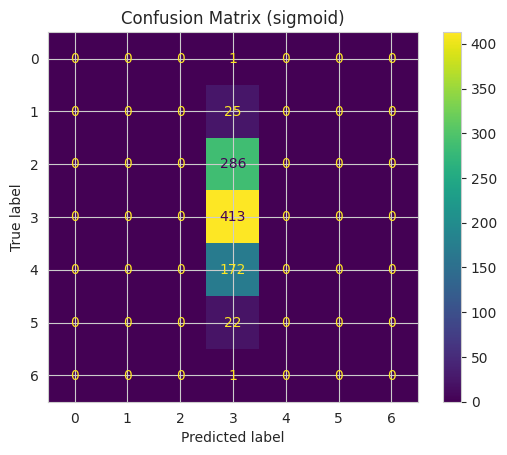

Treinamento concluído com a função de ativação Sigmoid.

Iniciando o treinamento com função de ativação Linear:


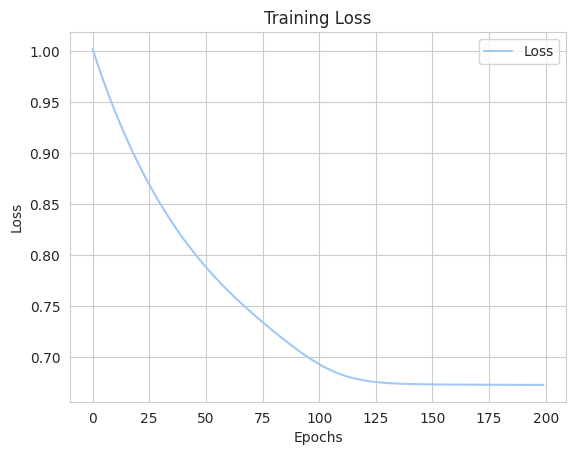

Accuracy: 0.4489
Precision: 0.7526
Recall: 0.4489
F1 Score: 0.2782


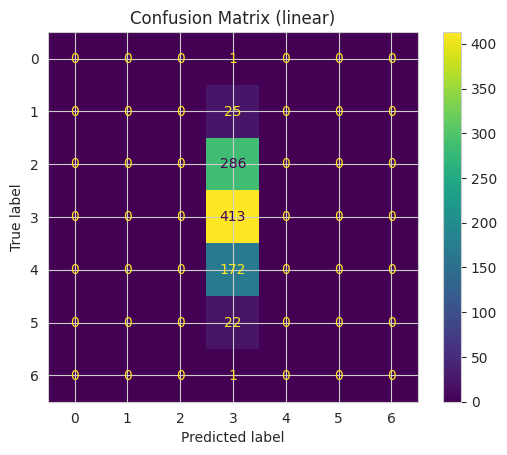

Treinamento concluído com a função de ativação Linear.


In [28]:
print("===================================")
print("Iniciando o treinamento com função de ativação Sigmoid:")
init_weights(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid.")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear:")
init_weights(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear.")
print("===================================")

# Experimentação com os pesos

In [29]:
def init_weights_he(X, y):
    # Inicialização dos pesos com o método de He
    np.random.seed(42)
    input_size = X.shape[1]
    hidden_size_1 = 10
    hidden_size_2 = 10
    output_size = y.shape[1]

    global W1, b1, W2, b2, W3, b3

    # Inicializar pesos e bias
    W1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden_size_1))

    W2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2. / hidden_size_1)
    b2 = np.zeros((1, hidden_size_2))

    W3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2. / hidden_size_2)
    b3 = np.zeros((1, output_size))

def init_weights_xavier(X, y):
    # Inicialização dos pesos com o método de Xavier
    np.random.seed(42)
    input_size = X.shape[1]
    hidden_size_1 = 10
    hidden_size_2 = 10
    output_size = y.shape[1]

    global W1, b1, W2, b2, W3, b3

    # Inicializar pesos e bias
    W1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size_1))

    W2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(1. / hidden_size_1)
    b2 = np.zeros((1, hidden_size_2))

    W3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(1. / hidden_size_2)
    b3 = np.zeros((1, output_size))

 ## Iris

In [30]:
# Separar variáveis independentes (features) e dependentes (classe)
features = ["sepal length", "sepal width", "petal length", "petal width"]

X = iris_df[features].values
y = iris_df["class"].values

# Codificar a classe (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))  # Transformar y para um vetor coluna antes de aplicar o encoding

# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Iniciando o treinamento com função de ativação Sigmoid (Inicialização de He):


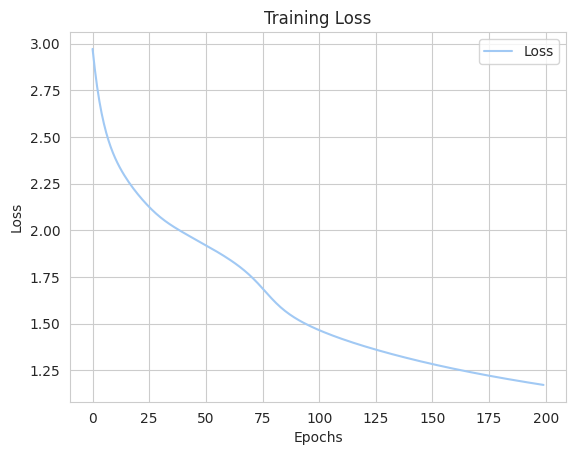

Accuracy: 0.8000
Precision: 0.8094
Recall: 0.8000
F1 Score: 0.8000


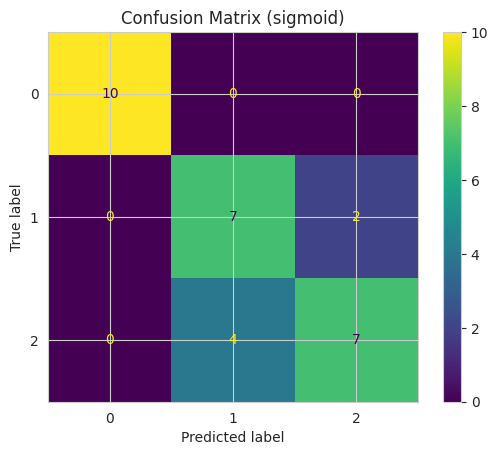

Treinamento concluído com a função de ativação Sigmoid (Inicialização de He).

Iniciando o treinamento com função de ativação Linear (Inicialização de He):


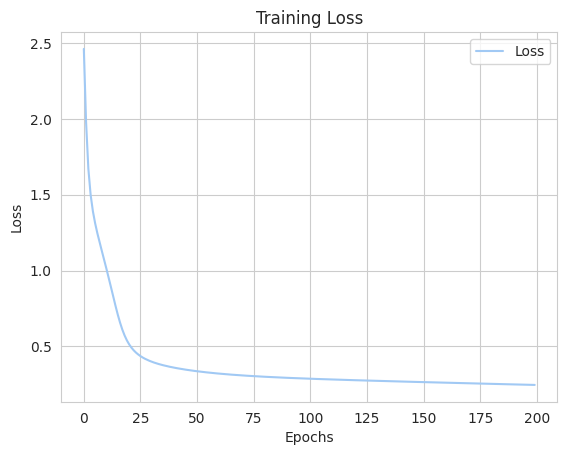

Accuracy: 0.8333
Precision: 0.8367
Recall: 0.8333
F1 Score: 0.8338


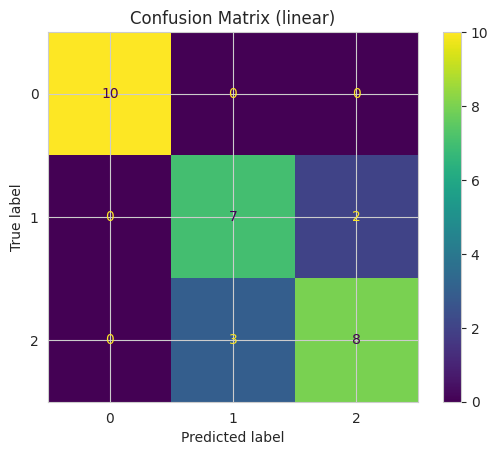

Treinamento concluído com a função de ativação Linear (Inicialização de He).

Iniciando o treinamento com função de ativação Sigmoid (Inicialização de Xavier):


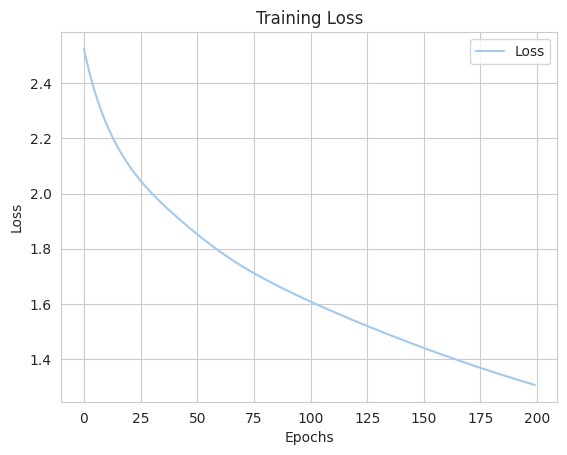

Accuracy: 0.7333
Precision: 0.8456
Recall: 0.7333
F1 Score: 0.6622


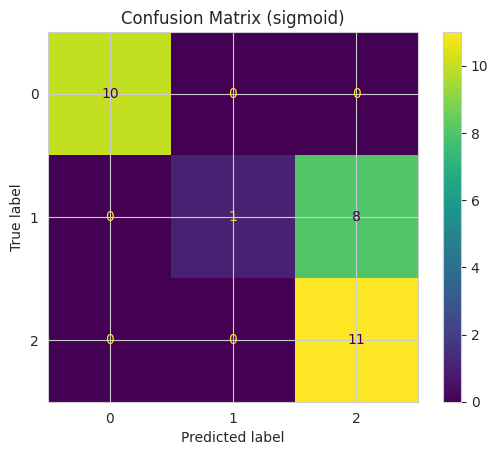

Treinamento concluído com a função de ativação Sigmoid (Inicialização de Xavier).

Iniciando o treinamento com função de ativação Linear (Inicialização de Xavier):


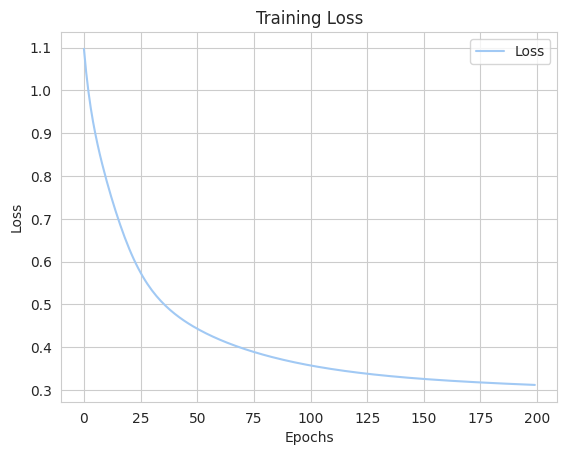

Accuracy: 0.7667
Precision: 0.7690
Recall: 0.7667
F1 Score: 0.7573


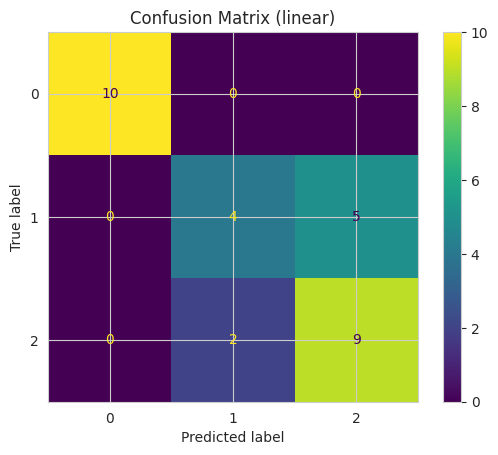

Treinamento concluído com a função de ativação Linear (Inicialização de Xavier).


In [31]:
print("===================================")
print("Iniciando o treinamento com função de ativação Sigmoid (Inicialização de He):")
init_weights_he(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid (Inicialização de He).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear (Inicialização de He):")
init_weights_he(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear (Inicialização de He).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Sigmoid (Inicialização de Xavier):")
init_weights_xavier(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid (Inicialização de Xavier).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear (Inicialização de Xavier):")
init_weights_xavier(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear (Inicialização de Xavier).")
print("===================================")

 ## Wine Quality

In [32]:
# Separar variáveis independentes (features) e dependentes (classe)
features = [
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density",
    "pH", "sulphates", "alcohol"
]

X = wine_df_cleaned[features].values
y = wine_df_cleaned["quality"].values

# Codificar a classe (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))  # Transformar y para um vetor coluna antes de aplicar o encoding

# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Iniciando o treinamento com função de ativação Sigmoid (Inicialização de He):


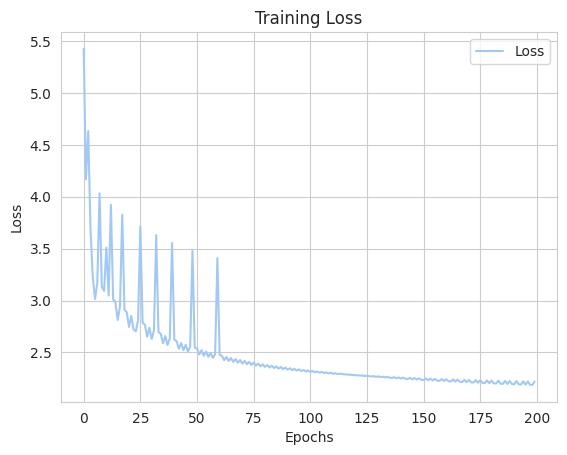

Accuracy: 0.4489
Precision: 0.7526
Recall: 0.4489
F1 Score: 0.2782


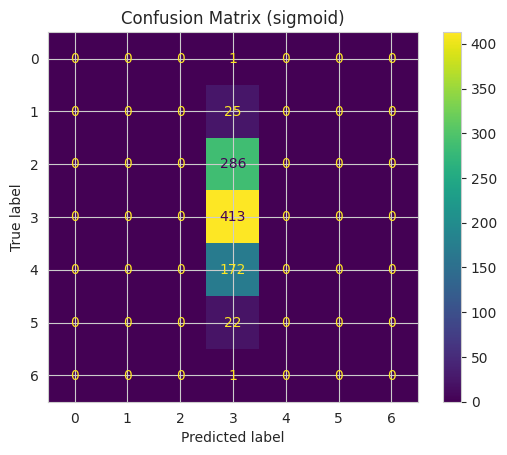

Treinamento concluído com a função de ativação Sigmoid (Inicialização de He).

Iniciando o treinamento com função de ativação Linear (Inicialização de He):


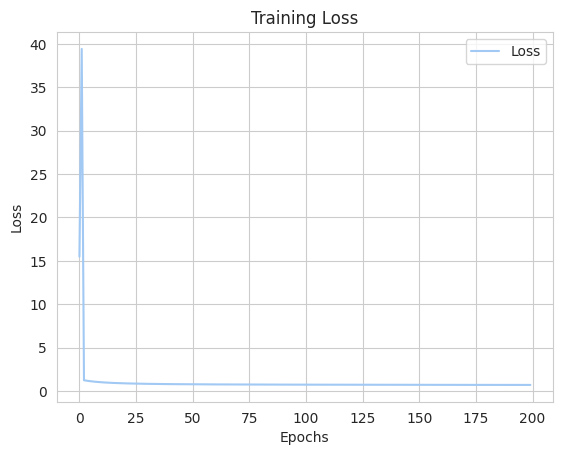

Accuracy: 0.4500
Precision: 0.4179
Recall: 0.4500
F1 Score: 0.2861


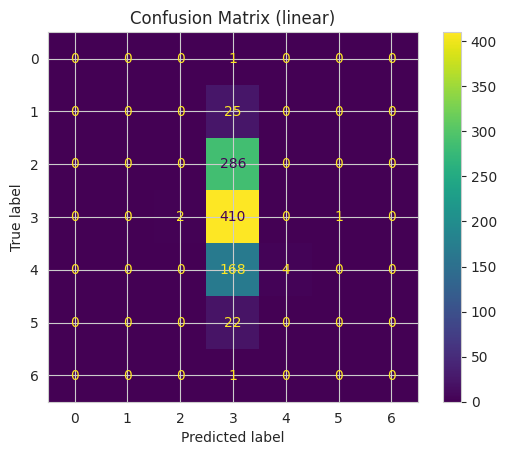

Treinamento concluído com a função de ativação Linear (Inicialização de He).

Iniciando o treinamento com função de ativação Sigmoid (Inicialização de Xavier):


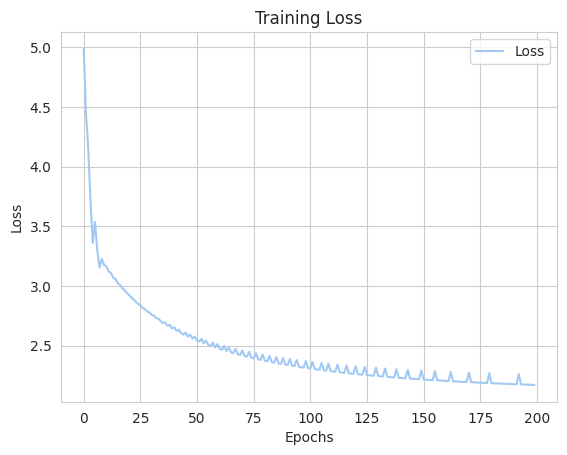

Accuracy: 0.4489
Precision: 0.7526
Recall: 0.4489
F1 Score: 0.2782


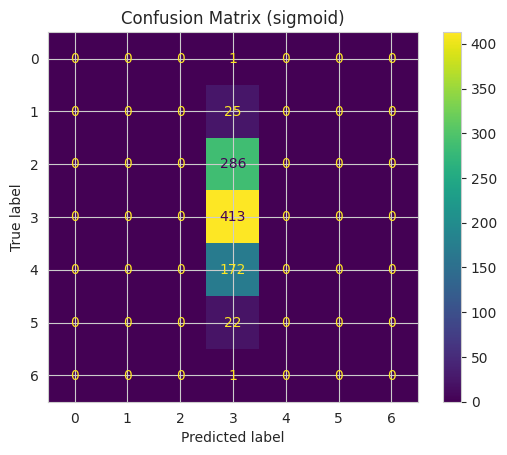

Treinamento concluído com a função de ativação Sigmoid (Inicialização de Xavier).

Iniciando o treinamento com função de ativação Linear (Inicialização de Xavier):


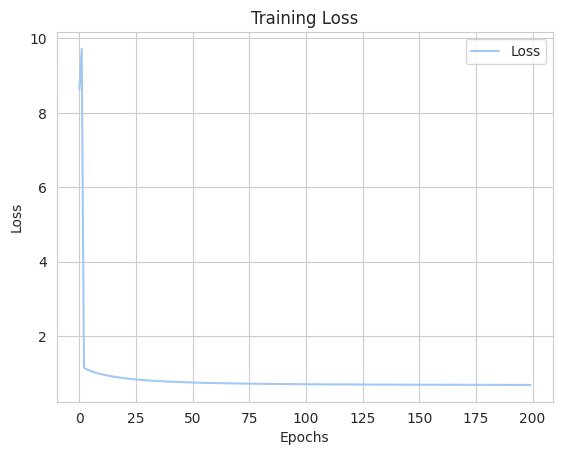

Accuracy: 0.4500
Precision: 0.4644
Recall: 0.4500
F1 Score: 0.2897


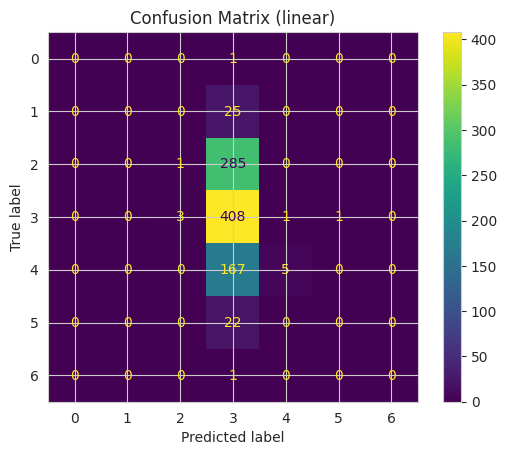

Treinamento concluído com a função de ativação Linear (Inicialização de Xavier).


In [33]:
print("===================================")
print("Iniciando o treinamento com função de ativação Sigmoid (Inicialização de He):")
init_weights_he(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid (Inicialização de He).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear (Inicialização de He):")
init_weights_he(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear (Inicialização de He).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Sigmoid (Inicialização de Xavier):")
init_weights_xavier(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="sigmoid")
evaluate(X_test, y_test, func="sigmoid")
print("Treinamento concluído com a função de ativação Sigmoid (Inicialização de Xavier).")
print("===================================")

print("\n===================================")
print("Iniciando o treinamento com função de ativação Linear (Inicialização de Xavier):")
init_weights_xavier(X, y)
train(X_train, y_train, epochs=200, learning_rate=0.01, func="linear")
evaluate(X_test, y_test, func="linear")
print("Treinamento concluído com a função de ativação Linear (Inicialização de Xavier).")
print("===================================")